<div id="table-of-contents" style="border: 1px solid #ddd; padding: 10px; max-width: 400px;">
  <h2>Table of Contents</h2>
  <ul>
    <li><a href="#overview">Overview</a></li>
    <li><a href="#data-loading">Data Loading</a></li>
    <li><a href="#data-summary">Data Summary</a></li>
    <li><a href="#exploratory-data-analysis">Exploratory Data Analysis</a>
      <ul>
        <li><a href="#matches">Match Analysis</a></li>
        <li><a href="#units">Unit Statistics</a></li>
        <li><a href="#items">Item Statistics</a></li>
        <li><a href="#traits">Trait Statistics</a></li>
        <li><a href="#comps">Team Composition Statistics</a></li>
      </ul>
    </li>
    <li><a href="#data-visualization">Data Visualization</a></li>
    <li><a href="#conclusion">Conclusion and Next Steps</a></li>
  </ul>
</div>

<p style="margin-top: 20px;">
  You can also read a more detailed version of this analysis in
  <a href="./summary.md" target="_blank">Insight Document</a>.
</p>

## Overview

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
# --- For data manipulation ---
import math
import pandas as pd
import numpy as np

# --- For plotting ---
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Seaborn
import seaborn as sns
# Plotly
import plotly.graph_objects as go
# Dash
from dash import Dash, dash_table, dcc, html, Input, Output

# --- For clustering ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- For retrieving images from URLs ---
import requests
from PIL import Image, ImageDraw
from io import BytesIO

# --- My custom functions ---
from src.data import make_statistic as statistic

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading

In [4]:
matches_df = statistic.load_matches()

In [5]:
participants_df = statistic.load_participants()

In [6]:
units_df = statistic.load_units()

In [7]:
traits_df = statistic.load_traits()

In [8]:
unit_traits_info, traits_info = statistic.load_units_and_traits_info(units_df, traits_df)

## Data Summary

In [9]:
matches_df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68037 entries, 0 to 68036
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   match_id        object        
 1   game_datetime   datetime64[ns]
 2   game_duration   float64       
 3   game_version    object        
 4   tft_set_number  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.6+ MB


<table style="width:1000px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:150px; border:1px solid #000;">Type</th>
      <th style="width:650px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>match_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique match identifier for the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>game_datetime</code></td>
      <td style="border:1px solid #000;"><em>datetime</em></td>
      <td style="border:1px solid #000;">Time where the game started</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>game_duration</code></td>
      <td style="border:1px solid #000;"><em>float</em></td>
      <td style="border:1px solid #000;">Duration of the game in seconds</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>tft_set_number</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">TFT set number of the game version</td>
    </tr>
  </tbody>
</table>

In [10]:
participants_df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544296 entries, 0 to 544295
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   game_version  object
 1   match_id      object
 2   puuid         object
 3   placement     int64 
 4   level         int64 
dtypes: int64(2), object(3)
memory usage: 20.8+ MB


<table style="width:1000px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:150px; border:1px solid #000;">Type</th>
      <th style="width:650px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>match_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique match identifier for the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>puuid</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique identifier for the player</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>placement</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Final position of the player in the match (1 = 1st place, 8 = last)</td>
    </tr>
        <tr>
      <td style="border:1px solid #000;"><code>level</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Player level at the end of the game</td>
    </tr>
  </tbody>
</table>

In [11]:
units_df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4674925 entries, 0 to 4674924
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   game_version  object
 1   match_id      object
 2   puuid         object
 3   character_id  object
 4   slot_idx      int64 
 5   rarity        int64 
 6   tier          int64 
 7   items         object
dtypes: int64(3), object(5)
memory usage: 285.3+ MB


<table style="width:1000px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:150px; border:1px solid #000;">Type</th>
      <th style="width:650px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>match_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique match identifier for the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>puuid</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique identifier for the player</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>character_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique identifier for the unit</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>slot_idx</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Slot index of the unit on the board</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>rarity</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Value of the unit (0 = 1 gold, 1 = 2 gold, 2 = 3 gold, 4 = 4 gold, 6 = 5 gold)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>tier</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Star of the unit (1 = 1 star, 2 = 2 stars, 3 = 3 stars, 4 = 4 stars)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>items</code></td>
      <td style="border:1px solid #000;"><em>list</em></td>
      <td style="border:1px solid #000;">Items the unit carries after the match</td>
    </tr>
  </tbody>
</table>

In [12]:
traits_df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166915 entries, 0 to 5166914
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   game_version  object
 1   match_id      object
 2   puuid         object
 3   trait_id      object
 4   num_units     int64 
 5   current_tier  int64 
 6   max_tier      int64 
 7   trait_style   int64 
dtypes: int64(4), object(4)
memory usage: 315.4+ MB


<table style="width:1000px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:150px; border:1px solid #000;">Type</th>
      <th style="width:650px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>match_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique match identifier for the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>puuid</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique identifier for the player</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>trait_id</code></td>
      <td style="border:1px solid #000;"><em>string</em></td>
      <td style="border:1px solid #000;">Unique identifier for the trait</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>num_units</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Number of units contributing to the trait bonus for that match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>current_tier</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Tier of the trait at the end of the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>max_tier</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Maximum achievable tier of the trait</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>trait_style</code></td>
      <td style="border:1px solid #000;"><em>int</em></td>
      <td style="border:1px solid #000;">Style of the trait (0: No style, 1: Bronze, 2: Silver, 3: Unique, 4: Gold, 5: Chromatic)</td>
    </tr>
  </tbody>
</table>

## Exploratory Data Analysis

### Matches

In [13]:
# Dataframe grouped by game_version and tft_set_number
game_vesrsion_df = matches_df.groupby(['game_version', 'tft_set_number']).agg(
    total_matches=('match_id', 'count'),
    average_duration=('game_duration', 'mean'),
).reset_index()
# Convert average_duration from seconds to minutes
game_vesrsion_df['average_duration'] = pd.to_datetime(game_vesrsion_df['average_duration'], unit='s').dt.strftime('%M:%S')

# Show results
game_vesrsion_df

game_version  tft_set_number  total_matches average_duration
0         15.8              14          37691            36:07
1         15.9              14          30346            36:06

### Units

#### Get unit statistics

In [14]:
# Get the basic units statistics
units_basic_stats_df = statistic.build_units_statistic_df(participants_df, units_df, basic=True)

# Show top 10 of the DataFrame
units_basic_stats_df.head(10)

game_version         character_id  rarity  frequency  avg_place    win  \
0         15.8           TFT14_Zyra       0      0.139       4.35  0.128   
1         15.8             TFT14_Vi       0      0.029       5.02  0.093   
2         15.8          TFT14_Sylas       0      0.161       4.47  0.108   
3         15.8          TFT14_Shaco       0      0.072       4.18  0.104   
4         15.8      TFT14_Seraphine       0      0.038       4.65  0.124   
5         15.8          TFT14_Poppy       0      0.060       4.39  0.122   
6         15.8  TFT14_NidaleeCougar       0      0.057       4.78  0.088   
7         15.8        TFT14_Morgana       0      0.101       4.40  0.109   
8         15.8         TFT14_KogMaw       0      0.049       4.41  0.098   
9         15.8        TFT14_Kindred       0      0.136       4.48  0.106   

    top4  
0  0.529  
1  0.414  
2  0.508  
3  0.575  
4  0.462  
5  0.520  
6  0.439  
7  0.523  
8  0.523  
9  0.504

**Dataset Overview:**

Total entries: 60 unique character IDs in each game version

Columns: 7

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>character_id</code></td>
      <td style="border:1px solid #000;">Unique identifier for the unit (60 unique units)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>rarity</code></td>
      <td style="border:1px solid #000;">Value of the unit</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>frequency</code></td>
      <td style="border:1px solid #000;">Proportion of usage, expressed as a percentage (%), showing how often the unit is used in games</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>avg_place</code></td>
      <td style="border:1px solid #000;">Average placement of the unit (lower than 4.5 is considered better)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>win</code></td>
      <td style="border:1px solid #000;">Win rate, representing the proportion of games where the unit finishes first</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">Top 4 rate, representing the proportion of games where the unit finishes in the top 4</td>
    </tr>
  </tbody>
</table>

#### Get unit item build statistic

In [15]:
# Get the full units statistics
units_items_stats_df = statistic.build_units_statistic_df(participants_df, units_df)

# Show top 10 of the DataFrame
pd.set_option('display.max_colwidth', None)
units_items_stats_df.head(10)

game_version character_id  rarity                       item_build  \
0         15.8   TFT14_Zyra       0  TFT14_Item_ControllerEmblemItem   
1         15.8   TFT14_Zyra       0      TFT14_Item_CutterEmblemItem   
2         15.8   TFT14_Zyra       0     TFT14_Item_DarkWebEmblemItem   
3         15.8   TFT14_Zyra       0  TFT14_Item_DivinicorpEmblemItem   
4         15.8   TFT14_Zyra       0    TFT14_Item_ImmortalEmblemItem   
5         15.8   TFT14_Zyra       0    TFT14_Item_MarksmanEmblemItem   
6         15.8   TFT14_Zyra       0     TFT14_Item_ThirstyEmblemItem   
7         15.8   TFT14_Zyra       0    TFT4_Item_OrnnRanduinsSanctum   
8         15.8   TFT14_Zyra       0     TFT5_Item_StatikkShivRadiant   
9         15.8   TFT14_Zyra       0     TFT5_Item_ZzRotPortalRadiant   

   frequency  avg_place  avg_delta    win   top4  
0      0.002       3.82      -0.53  0.189  0.608  
1      0.001       4.42       0.07  0.152  0.545  
2      0.001       4.32      -0.03  0.136  0.545  
3      0.001       4.17      -0.18  0.171  0.543  
4      0.001       3.62      -0.72  0.333  0.667  
5      0.001       3.73      -0.62  0.227  0.591  
6      0.001       4.56       0.21  0.259  0.444  
7      0.003       4.74       0.39  0.103  0.463  
8      0.003       4.35       0.00  0.113  0.540  
9      0.001       4.33      -0.02  0.083  0.500

**Dataset Overview:**

Total entries: 60 unique character IDs in each game version

Columns: 8

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>character_id</code></td>
      <td style="border:1px solid #000;">Unique identifier for the unit (60 unique units)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>rarity</code></td>
      <td style="border:1px solid #000;">Value of the unit</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>item_build</code></td>
      <td style="border:1px solid #000;">List of items that this unit carries</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>frequency</code></td>
      <td style="border:1px solid #000;">Proportion of usage, expressed as a percentage (%), showing how often the unit has this item build is used in games</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>avg_place</code></td>
      <td style="border:1px solid #000;">Average placement of the unit (lower than 4.5 is considered better)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>win</code></td>
      <td style="border:1px solid #000;">Win rate, representing the proportion of games where the unit has this item build finishes first</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">Top 4 rate, representing the proportion of games where the unit has this item build finishes in the top 4</td>
    </tr>
  </tbody>
</table>

### Items

In [16]:
# Get the full items statistics
items_stats_df = statistic.build_items_statistic_df(participants_df, units_df)

# Show top 10 of the DataFrame
pd.reset_option('display.max_colwidth')
items_stats_df.head(10)

game_version                     items  frequency  play_rate  avg_place  \
0         15.8     TFT_Item_AdaptiveHelm      0.209       1.67       4.03   
1         15.8  TFT_Item_ArchangelsStaff      0.199       1.59       4.23   
2         15.8    TFT_Item_Bloodthirster      0.382       3.05       4.16   
3         15.8         TFT_Item_BlueBuff      0.269       2.15       4.28   
4         15.8      TFT_Item_BrambleVest      0.278       2.23       4.17   
5         15.8       TFT_Item_Crownguard      0.207       1.66       4.09   
6         15.8       TFT_Item_Deathblade      0.129       1.03       3.94   
7         15.8      TFT_Item_DragonsClaw      0.261       2.09       4.31   
8         15.8    TFT_Item_ForceOfNature      0.044       0.35       4.36   
9         15.8      TFT_Item_FrozenHeart      0.321       2.57       4.14   

     win   top4                                          top_units       type  
0  0.153  0.591  [{'character_id': 'TFT14_Sejuani', 'frequency'...  Craftable  
1  0.144  0.553  [{'character_id': 'TFT14_Fiddlesticks', 'frequ...  Craftable  
2  0.167  0.562  [{'character_id': 'TFT14_Viego', 'frequency': ...  Craftable  
3  0.149  0.540  [{'character_id': 'TFT14_Vex', 'frequency': 0....  Craftable  
4  0.141  0.564  [{'character_id': 'TFT14_Leona', 'frequency': ...  Craftable  
5  0.152  0.576  [{'character_id': 'TFT14_Viego', 'frequency': ...  Craftable  
6  0.166  0.608  [{'character_id': 'TFT14_Senna', 'frequency': ...  Craftable  
7  0.132  0.536  [{'character_id': 'TFT14_Mordekaiser', 'freque...  Craftable  
8  0.140  0.525  [{'character_id': 'TFT14_Aurora', 'frequency':...  Craftable  
9  0.148  0.570  [{'character_id': 'TFT14_Sejuani', 'frequency'...  Craftable

**Dataset Overview:**

Total entries: 152 unique item IDs in each game version

Columns: 9

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>items</code></td>
      <td style="border:1px solid #000;">Unique identifier for the item (152 unique items)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>frequency</code></td>
      <td style="border:1px solid #000;">Proportion of usage, expressed as a percentage (%), showing how often the item is used in games</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>play_rate</code></td>
      <td style="border:1px solid #000;">Proportion of usage (range: 0 to 8), showing the number of players (out of 8) using the item in a single match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>avg_place</code></td>
      <td style="border:1px solid #000;">Average placement of players using the item (lower than 4.5 is considered better)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>win</code></td>
      <td style="border:1px solid #000;">Win rate, representing the proportion of games where the item contributed to a first-place finish</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">Top 4 rate, representing the proportion of games where the item contributed to a top 4 finish</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">List of the top 10 units that carry this item most frequently, including related stats such as frequency, avg_place, unit_delta, item_delta, win, and top4</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>type</code></td>
      <td style="border:1px solid #000;">The item type (e.g., <b>Craftable</b>: made from two components, <b>Radiant</b>: enhanced version of a craftable item, etc.)</td>
    </tr>
  </tbody>
</table>

### Traits

In [17]:
# Get the full traits statistics
traits_stats_df = statistic.build_traits_statistic_df(participants_df, traits_df, traits_info)

# Show top 10 of the DataFrame
traits_stats_df.head(10)

game_version          trait_id  current_tier  max_tier  trait_style  \
0         15.8  TFT14_AnimaSquad             1         4            1   
1         15.8  TFT14_AnimaSquad             2         4            2   
2         15.8  TFT14_AnimaSquad             3         4            4   
3         15.8  TFT14_AnimaSquad             4         4            5   
4         15.8   TFT14_Armorclad             1         3            1   
5         15.8   TFT14_Armorclad             2         3            2   
6         15.8   TFT14_Armorclad             3         3            4   
7         15.8   TFT14_BallisTek             1         3            1   
8         15.8   TFT14_BallisTek             2         3            2   
9         15.8   TFT14_BallisTek             3         3            4   

   min_units_required  play_rate  avg_place    win   top4  
0                   3       1.35       4.29  0.142  0.536  
1                   5       0.06       3.94  0.159  0.622  
2                   7       0.24       4.97  0.069  0.401  
3                  10       0.02       1.53  0.754  0.955  
4                   2       2.66       4.51  0.110  0.500  
5                   4       0.64       4.34  0.175  0.526  
6                   6       0.08       3.85  0.242  0.606  
7                   2       0.54       4.65  0.091  0.475  
8                   4       0.12       4.16  0.154  0.565  
9                   6       0.06       3.96  0.200  0.579

**Dataset Overview:**

Total entries: 25 unique trait IDs with 76 rows in each game version

Columns: 10

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>trait_id</code></td>
      <td style="border:1px solid #000;">Unique identifier for the trait (25 unique traits)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>current_tier</code></td>
      <td style="border:1px solid #000;">Tier of the trait at the end of the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>max_tier</code></td>
      <td style="border:1px solid #000;">Maximum achievable tier of the trait</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>trait_style</code></td>
      <td style="border:1px solid #000;">Style of the trait (0 = No style, 1 = Bronze, 2 = Silver, 3 = Unique, 4 = Gold, 5 = Chromatic)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>min_units_required</code></td>
      <td style="border:1px solid #000;">Number of units contributing to the trait bonus for that match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>play_rate</code></td>
      <td style="border:1px solid #000;">Proportion of usage (range: 0 to 8), showing the number of players (out of 8) using the item in a single match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>avg_place</code></td>
      <td style="border:1px solid #000;">Average placement of the unit (lower than 4.5 is considered better)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>win</code></td>
      <td style="border:1px solid #000;">Win rate, representing the proportion of games where the trait finishes first</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">Top 4 rate, representing the proportion of games where the trait finishes in the top 4</td>
    </tr>
  </tbody>
</table>

### Comps

#### Get all compositions available

In [18]:
# Get all compositions
comps_df = statistic.build_comps_df(participants_df, units_df, traits_df)

In [ ]:
# Show top 8 compositions do not have any emblem
cols = ['game_version', 'match_id', 'placement', 'level', 'combine_units', 'combine_active_traits', 'has_emblem', 'emblems']
comps_df[cols].head(8)

game_version       match_id  placement  level  \
0         15.8  VN2_834760605          1      9   
1         15.8  VN2_834760605          2      9   
2         15.8  VN2_834760605          3      9   
3         15.8  VN2_834760605          4      8   
4         15.8  VN2_834760605          5      9   
5         15.8  VN2_834760605          6      9   
6         15.8  VN2_834760605          7      9   
7         15.8  VN2_834760605          8      8   

                                       combine_units  \
0  (TFT14_DrMundo_0, TFT14_Poppy_0, TFT14_Seraphi...   
1  (TFT14_Sylas_0, TFT14_Jhin_1, TFT14_Braum_2, T...   
2  (TFT14_Poppy_0, TFT14_Ekko_1, TFT14_Annie_4, T...   
3  (TFT14_Sylas_0, TFT14_Rhaast_1, TFT14_Vayne_1,...   
4  (TFT14_Seraphine_0, TFT14_Sylas_0, TFT14_Illao...   
5  (TFT14_Kindred_0, TFT14_NidaleeCougar_0, TFT14...   
6  (TFT14_NidaleeCougar_0, TFT14_Shyvana_1, TFT14...   
7  (TFT14_Sylas_0, TFT14_Jhin_1, TFT14_Rhaast_1, ...   

                               combine_active_traits  has_emblem  \
0  (TFT14_Techie_7_3, TFT14_StreetDemon_3_1, TFT1...       False   
1  (TFT14_Marksman_4_2, TFT14_Vanguard_4_2, TFT14...        True   
2  (TFT14_Controller_3_2, TFT14_StreetDemon_3_1, ...       False   
3  (TFT14_Strong_4_2, TFT14_Vanguard_4_2, TFT14_A...        True   
4  (TFT14_AnimaSquad_7_3, TFT14_Armorclad_2_1, TF...       False   
5  (TFT14_HotRod_4_2, TFT14_Immortal_2_1, TFT14_S...       False   
6  (TFT14_Supercharge_3_2, TFT14_HotRod_3_1, TFT1...       False   
7  (TFT14_Marksman_4_2, TFT14_Vanguard_4_2, TFT14...       False   

            emblems  
0                []  
1  [TFT14_Marksman]  
2                []  
3  [TFT14_Immortal]  
4                []  
5                []  
6                []  
7                []

**Dataset Overview:**

Total entries: All valid compositions (without incomplete trait lists, such as 2 out of 3 required to activate a trait) in each game version.

Columns: 11

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>match_id</code></td>
      <td style="border:1px solid #000;">Unique match identifier for the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>puuid</code></td>
      <td style="border:1px solid #000;">Unique identifier for the player</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>placement</code></td>
      <td style="border:1px solid #000;">Final position of the player in the match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level</code></td>
      <td style="border:1px solid #000;">Player level at the end of the game</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>combine_units</code></td>
      <td style="border:1px solid #000;">A string that combines all units in the composition, including their rarity information</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>combine_full_units</code></td>
      <td style="border:1px solid #000;">A string that combines all units in the composition, including their rarity and tier information</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>combine_active_traits</code></td>
      <td style="border:1px solid #000;">A string that combines all active traits in the composition, including their tier and num_units information</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>combine_full_traits</code></td>
      <td style="border:1px solid #000;">A string that combines all traits (even inactive ones) in the composition, including their tier and num_units information</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>has_emblem</code></td>
      <td style="border:1px solid #000;">Indicates whether the composition contains an additional trait provided by an emblem</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>emblems</code></td>
      <td style="border:1px solid #000;">List of emblems if <em>has_emblem</em> is True</td>
    </tr>
  </tbody>
</table>

#### Frequent Itemset Mining

In [20]:
# Apply to all normal compositions before grouping
normal_comps = (
    comps_df[(comps_df['has_emblem'] == False) & (comps_df['level'] >= 7) & (comps_df['level'] <= 9)]
    .groupby(['game_version', 'level'])['combine_units']
    .apply(list)
    .to_dict()
)

# Frequent normal compositions
frequent_normal_comps_df = (
    statistic.build_frequent_comps_by_version(
        normal_comps, 
        unit_traits_info=unit_traits_info, 
        traits_info=traits_info
    )
)

In [21]:
# Get the frequent normal compositions statistics by game version
deduplicate_frequent_normal_comps_df = statistic.deduplicate_comps(frequent_normal_comps_df)
# Remove level 9 compositions
deduplicate_frequent_normal_comps_df = deduplicate_frequent_normal_comps_df[deduplicate_frequent_normal_comps_df['level'] != 9].copy()

In [22]:
# Get the frequent emblem compositions statistics by game version
comps_stats_df = statistic.build_comps_statistic_df(comps_df, deduplicate_frequent_normal_comps_df, unit_traits_info, traits_info)
# Show top 10 of the DataFrame
comps_stats_df.head(5)

game_version                                            level_7  \
0         15.8  (TFT14_Sylas_0_2, TFT14_Rhaast_1_2, TFT14_Vayn...   
1         15.8  (TFT14_Kindred_0_3, TFT14_NidaleeCougar_0_3, T...   
2         15.8  (TFT14_Jax_0_2, TFT14_Kindred_0_3, TFT14_Nidal...   
3         15.8  (TFT14_Alistar_0_2, TFT14_DrMundo_0_2, TFT14_D...   
4         15.8  (TFT14_DrMundo_0_2, TFT14_Zyra_0_2, TFT14_Ekko...   

                                      level_7_traits  \
0  {'TFT14_AnimaSquad': 3, 'TFT14_Vanguard': 4, '...   
1  {'TFT14_HotRod': 4, 'TFT14_Marksman': 2, 'TFT1...   
2  {'TFT14_EdgeRunner': 3, 'TFT14_Armorclad': 2, ...   
3  {'TFT14_Bruiser': 6, 'TFT14_BallisTek': 2, 'TF...   
4  {'TFT14_StreetDemon': 7, 'TFT14_Techie': 2, 'T...   

                                             level_8  \
0  (TFT14_Sylas_0_2, TFT14_Rhaast_1_2, TFT14_Vayn...   
1  (TFT14_Kindred_0_3, TFT14_NidaleeCougar_0_3, T...   
2  (TFT14_Jax_0_3, TFT14_Kindred_0_3, TFT14_Nidal...   
3  (TFT14_Alistar_0_2, TFT14_DrMundo_0_2, TFT14_D...   
4  (TFT14_DrMundo_0_2, TFT14_Zyra_0_2, TFT14_Ekko...   

                                      level_8_traits  \
0  {'TFT14_AnimaSquad': 3, 'TFT14_Vanguard': 4, '...   
1  {'TFT14_HotRod': 4, 'TFT14_Marksman': 2, 'TFT1...   
2  {'TFT14_EdgeRunner': 3, 'TFT14_Armorclad': 2, ...   
3  {'TFT14_Bruiser': 6, 'TFT14_BallisTek': 2, 'TF...   
4  {'TFT14_StreetDemon': 7, 'TFT14_Techie': 2, 'T...   

                                             level_9  \
0  (TFT14_Sylas_0_2, TFT14_Rhaast_1_2, TFT14_Vayn...   
1  (TFT14_Kindred_0_3, TFT14_NidaleeCougar_0_3, T...   
2  (TFT14_Jax_0_2, TFT14_Kindred_0_2, TFT14_Nidal...   
3  (TFT14_Alistar_0_2, TFT14_DrMundo_0_2, TFT14_D...   
4  (TFT14_DrMundo_0_2, TFT14_Zyra_0_2, TFT14_Ekko...   

                                      level_9_traits  play_rate  avg_place  \
0  {'TFT14_AnimaSquad': 3, 'TFT14_Vanguard': 4, '...       0.39   3.715185   
1  {'TFT14_HotRod': 4, 'TFT14_Marksman': 2, 'TFT1...       0.10   4.246683   
2  {'TFT14_EdgeRunner': 3, 'TFT14_Armorclad': 2, ...       0.05   5.006215   
3  {'TFT14_Bruiser': 6, 'TFT14_BallisTek': 3, 'TF...       0.04   5.591153   
4  {'TFT14_StreetDemon': 7, 'TFT14_Bruiser': 2, '...       0.12   3.763908   

     win   top4  
0  0.160  0.658  
1  0.120  0.539  
2  0.051  0.393  
3  0.046  0.290  
4  0.235  0.626

**Dataset Overview:**

Total entries: All valid compositions (without incomplete trait lists, such as 2 out of 3 required to activate a trait) in each game version.

Columns: 11

<table style="width:1200px; border-collapse:collapse;">
  <thead style="background-color:#aaaaaa">
    <tr>
      <th style="width:200px; border:1px solid #000;">Column</th>
      <th style="width:1000px; border:1px solid #000;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #000;"><code>game_version</code></td>
      <td style="border:1px solid #000;">Game patch version indicates the TFT set version</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_7</code></td>
      <td style="border:1px solid #000;">All unit compositions at level 7</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_7_traits</code></td>
      <td style="border:1px solid #000;">All trait in compositions at level 7</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_8</code></td>
      <td style="border:1px solid #000;">All unit compositions at level 8</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_8_traits</code></td>
      <td style="border:1px solid #000;">All trait in compositions at level 8</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_9</code></td>
      <td style="border:1px solid #000;">All unit compositions at level 9</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>level_9_traits</code></td>
      <td style="border:1px solid #000;">All trait in compositions at level 9</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>play_rate</code></td>
      <td style="border:1px solid #000;">Proportion of usage (range: 0 to 8), showing the number of players (out of 8) using this comp in a single match</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>avg_place</code></td>
      <td style="border:1px solid #000;">Average placement of the comp (lower than 4.5 is considered better)</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>win</code></td>
      <td style="border:1px solid #000;">Win rate, representing the proportion of games where the comp finishes first</td>
    </tr>
    <tr>
      <td style="border:1px solid #000;"><code>top4</code></td>
      <td style="border:1px solid #000;">Top 4 rate, representing the proportion of games where the comp finishes in the top 4</td>
    </tr>
  </tbody>
</table>

## Data Visualization

In [23]:
version = matches_df['game_version'].unique()[0] + '.1'

# --- Read the trait data from the API ---
trait_url = f'https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/tft-trait.json'
trait_data = requests.get(trait_url).json()['data']
trait_ids = traits_df['trait_id'].unique()
# Map: trait_id -> image URL
trait_icons = {trait['id']: f'https://ddragon.leagueoflegends.com/cdn/{version}/img/tft-trait/{trait["image"]["full"]}' for trait in trait_data.values() if trait['id'] in trait_ids}

# --- Read the unit data from the API ---
unit_url = f'https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/tft-champion.json'
unit_data = requests.get(unit_url).json()['data']
unit_ids = units_df['character_id'].unique()

# Map: unit_id -> image URL
unit_icons = {unit['id']: f'https://ddragon.leagueoflegends.com/cdn/{version}/img/tft-champion/{unit["image"]["full"]}' for unit in unit_data.values() if unit['id'] in unit_ids}

# --- Read the item data from the API ---
item_url = f'https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/tft-item.json'
item_data = requests.get(item_url).json()['data']

# Map: item_id -> item name
item_names = {item['id']: item['name'] for item in item_data.values() if 'TFTTutorial' not in item['id']}
# Map: item_id -> image URL
item_icons = {item['id']: f'https://ddragon.leagueoflegends.com/cdn/{version}/img/tft-item/{item["image"]["full"]}' for item in item_data.values() if 'TFTTutorial' not in item['id']}

### Units EDA

#### Units performance

In [24]:
def load_square_image(image_bytes: bytes):
    img = Image.open(BytesIO(image_bytes)).convert("RGBA")
    if img.width > 128:
        img = img.crop((img.width - 128, 0, img.width, 128))
    return img

def add_border(img: Image.Image, rarity=None, border_width=5):
    rarity_colors = {
        0: (160, 155, 140, 255), # Gray
        1: (0, 185, 110, 255),   # Green
        2: (30, 120, 242, 255),  # Blue
        4: (183, 85, 255, 255),  # Purple
        6: (248, 177, 62, 255),  # Gold
    }
    
    # Default to black if rarity is not provided
    border_color = rarity_colors.get(rarity, (0, 0, 0, 255))

    w, h = img.size
    bordered = Image.new("RGBA", (w, h), (0, 0, 0, 0))
    bordered.paste(img, (0, 0))

    draw = ImageDraw.Draw(bordered)
    for i in range(border_width):
        draw.rectangle([i, i, w - 1 - i, h - 1 - i], outline=border_color)

    return bordered

def process_unit_image_with_rarity(image_bytes: bytes, rarity: int):
    img = load_square_image(image_bytes)
    return add_border(img, rarity)

In [25]:
def plotly_unit_by_version(units_stats_df, version, unit_icons):
    version_data = units_stats_df[units_stats_df['game_version'] == version].copy()
    
    # Sort by rarity
    version_data.sort_values(by='rarity', ascending=True, inplace=True)
    version_data['frequency'] = round(version_data['frequency'] * 100, 1)
    version_data['inv_avg_place'] = -version_data['avg_place']
    
    # Normalize the data
    coords = version_data[['inv_avg_place', 'frequency', 'win', 'top4']].values
    scaler = StandardScaler()
    coords = scaler.fit_transform(coords)
    
    # Cluster
    kmeans = KMeans(n_clusters=5, random_state=25, n_init='auto')
    clusters = kmeans.fit_predict(coords)
    version_data['cluster'] = clusters
    
    # Cluster to tier mapping
    cluster_centers = kmeans.cluster_centers_
    cluster_scores = cluster_centers.mean(axis=1)
    cluster_ranking = np.argsort(-cluster_scores)
    cluster_tiers = {
        cluster_idx: ['S', 'A', 'B', 'C', 'D'][rank]
        for rank, cluster_idx in enumerate(cluster_ranking)
    }
    tier_colors = {
        'S': 'rgb(239, 68, 68)',     # Red
        'A': 'rgb(249, 115, 22)',    # Orange
        'B': 'rgb(234, 179, 8)',     # Yellow
        'C': 'rgb(74, 222, 128)',    # Green
        'D': 'rgb(107, 114, 128)',   # Gray
    }
    
    fig = go.Figure()
    
    # --- Draw the clusters boundaries ---
    for cluster_label in sorted(version_data['cluster'].unique()):
        # Calculate the center and radius of the cluster
        cluster_data = version_data[version_data['cluster'] == cluster_label]
        center_y = cluster_data['frequency'].mean()
        center_x = cluster_data['avg_place'].mean()
        center = np.array([center_x, center_y])
        radius_x = (cluster_data['avg_place'].max() - cluster_data['avg_place'].min()) / 2 + 0.05
        radius_y = (cluster_data['frequency'].max() - cluster_data['frequency'].min()) / 2 + 1
        # Calculate the ellipse points
        theta = np.linspace(0, 2 * np.pi, 100)
        x_ellipse = center[0] + radius_x * np.cos(theta)
        y_ellipse = center[1] + radius_y * np.sin(theta)

        # Tier label and color
        tier_label = cluster_tiers[cluster_label]
        ellipse_color = tier_colors[tier_label]
        
        # Draw the ellipse
        fig.add_trace(go.Scatter(
            x=x_ellipse, y=y_ellipse,
            mode='lines',
            line=dict(color=ellipse_color, dash='dot', width=3),
            hovertext=f"<b>Tier: {tier_label}</b>",
            hoverinfo='text',
            showlegend=False
        ))
    
    # --- Draw the scatter data points ---
    fig.add_trace(go.Scatter(
        x=version_data['avg_place'],
        y=version_data['frequency'],
        mode='markers',
        marker=dict(size=10, color='rgba(0, 0, 0, 0)'),
        text=version_data['character_id'],
        hovertext=[
            f"<span style='font-size:16px'><b>{row['character_id'].split('_')[1]}</b></span>"
            f"<br>Tier: {cluster_tiers[row['cluster']]}"
            f"<br>Play Rate: {row['frequency']:.1f}%"
            f"<br>Avg Place: {row['avg_place']:.2f}"
            for _, row in version_data.iterrows()
        ],
        hoverinfo="text",
        showlegend=False
    ))

    # --- Find the min and max values for the axes ---
    x_max = math.ceil((version_data['avg_place'].max() + 0.03) * 10) / 10
    x_min = math.floor((version_data['avg_place'].min() - 0.03) * 10) / 10
    y_max = math.ceil((version_data['frequency'].max() + 2) / 5) * 5
    y_min = math.floor((version_data['frequency'].min() - 2) / 5) * 5
    
    # --- Set the image size ---
    img_width = 0.075 * (x_max - x_min)
    img_height = 0.075 * (y_max - y_min)
    
    # --- Draw the unit images ---
    for _, row in version_data.iterrows():
        x, y = row['avg_place'], row['frequency']
        rarity = row['rarity']
        char_id = row['character_id']

        if char_id in unit_icons:
            try:
                response = requests.get(unit_icons[char_id])
                if response.status_code == 200:
                    img = process_unit_image_with_rarity(response.content, rarity)
                    fig.add_layout_image(
                        dict(
                            source=Image.fromarray(np.array(img)),
                            xref="x", yref="y",
                            x=x, y=y,
                            sizex=img_width, sizey=img_height,
                            xanchor="center", yanchor="middle", layer="above"
                        )
                    )
            except Exception:
                pass
            
    # Add legend entries for tiers
    for tier_label, color in tier_colors.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=12, color=color),
            name=f"Tier {tier_label}"
        ))
    
    # --- Set the layout ---
    fig.update_layout(
        title=dict(
            text=f"<b>Unit Performance v.{version}</b>",
            x=0.5,
            xanchor='center',
            font=dict(size=20, family='Arial', color='black')
        ),
        xaxis_title=dict(
            text="Average Placement",
            font=dict(size=12, family='Arial', color='black')
        ),
        yaxis_title=dict(
            text="Frequency Percent",
            font=dict(size=12, family='Arial', color='black')
        ),
        hovermode="closest",
        width=1200, height=675,
        paper_bgcolor='white', plot_bgcolor='white',
        xaxis=dict(
            range=[x_min, x_max],
            tickmode='array', tickvals=[round(x, 1) for x in np.arange(x_min, x_max + 0.1, 0.1)],
            showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.3)', 
            zeroline=False, linecolor='black',
            linewidth=1, mirror=True
        ),
        yaxis=dict(
            range=[y_min, y_max],
            tickmode='array', tickvals=[y for y in np.arange(max(0, y_min), y_max + 5, 5)],
            showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.3)',
            zeroline=False, linecolor='black',
            linewidth=1, mirror=True
        ),
        legend=dict(
            title="Tier Legend",
            orientation="v",                    # Vertical stack
            x=0.996, y=0.99,
            xanchor="right", yanchor="top",
            bgcolor="rgba(255, 255, 255, 0.5)", # Semi-transparent background
            bordercolor="black",
            borderwidth=1
        )
    )

    fig.show()

In [26]:
plotly_unit_by_version(units_basic_stats_df, version='15.8', unit_icons=unit_icons)

In [27]:
plotly_unit_by_version(units_basic_stats_df, version='15.9', unit_icons=unit_icons)

---

<strong>Unit Performance Summary</strong>

---

Tier S (Red Dot Ellipse):

- *Performance*: These are the *best-performing* units, having the lowest average placements in the plot and a decent frequency of appearance, despite being the rarest units to find on the board.
- *Role*: Typically, they are powerful five-cost units that serve as *win conditions* or *high-impact additions* in late-game compositions.

Tier A (Orange Dot Ellipse):

- *Performance*: Units with slightly higher average placements than Tier S, but still *impactful* and *commonly* used due to their high frequency of appearance.
- *Role*: Units that are often *contested* in the game; generally *key* units for popular team comps in each game version.

Tier B (Yellow Dotted Ellipse):

- *Performance*: *Moderately* effective units with average placement values around the middle range.
- *Role*: Often *situational picks* that fit into certain team comps, depending on specific items or augments that enhance their overall power.

Tier C (Green Dotted Ellipse):

- *Performance*: Units with *higher* average placements (i.e., they perform worse), but *still appear* in specific team compositions.
- *Role*: Generally *filler* or *synergy-enabling* units that are composition-dependent and not frequently prioritized.

Tier D (Gray Dotted Ellipse):

- *Performance*: The *weakest* units, with poor average placements and low usage rates.
- *Role*: Rarely used due to underperformance or a lack of synergy with current meta strategies.

---

#### Items performance

In [28]:
def process_item_image(image_bytes: bytes):
    img = Image.open(BytesIO(image_bytes)).convert("RGBA")
    return add_border(img, border_width=5)

In [29]:
# Initialize the app
app = Dash(__name__)

# Layout
app.layout = html.Div([
    # Header
    html.Div([
        # Title
        html.Div("Item Performance Dashboard", style={'position': 'absolute', 'left': '50%', 'transform': 'translateX(-50%)', 'fontSize': '30px', 'fontWeight': 'bold'
        }),

        # Dropdown group on the left
        html.Div([
            dcc.Dropdown(
                id='item-type-dropdown',
                options=['Craftable', 'Emblem', 'Radiant', 'Artifact', 'Support', 'ExotechItem'],
                value='Craftable',
                clearable=False,
                style={'width': '200px', 'height': '40px', 'paddingLeft': '10px'}
            ),
            dcc.Dropdown(
                id='version-dropdown',
                options=[{'label': v, 'value': v} for v in sorted(items_stats_df['game_version'].unique())],
                value=sorted(items_stats_df['game_version'].unique())[-1],
                clearable=False,
                style={'width': '100px', 'height': '40px'}
            )
        ], style={'display': 'flex', 'gap': '10px'})
    ], style={'position': 'relative', 'display': 'flex', 'alignItems': 'center', 'height': '50px', 'marginBottom': '20px'}),

    # Horizontal Layout Container
    html.Div([
        # Scatter Plot on the Left
        dcc.Graph(
            id='scatter-plot',
            style={'width': '850px', 'height': '540px', 'backgroundColor': 'black'}
        ),
        # Unit Table on the Right
        html.Div(
            id='unit-table-container',
            style={'width': '650px', 'maxHeight': '540px', 'overflowY': 'auto', 'backgroundColor': 'white'}
        )
    ], style={'display': 'flex', 'width': '1500px', 'height': '540px', 'gap': '0'})
], style={'backgroundColor': 'white', 'width': '1500px', 'height': '600px'})

# Callback to update the scatter plot based on dropdown selections
@app.callback(
    Output('scatter-plot', 'figure'),
    Input('item-type-dropdown', 'value'),
    Input('version-dropdown', 'value')
)
def update_scatter(selected_type, selected_version):
    # Filter by both type and version
    filtered_type_df = items_stats_df[(items_stats_df['type'] == selected_type) & (items_stats_df['game_version'] == selected_version)].copy()
    filtered_type_df['frequency'] = round(filtered_type_df['frequency'] * 100, 1)
    filtered_type_df['win'] = round(filtered_type_df['win'] * 100, 1)
    filtered_type_df['top4'] = round(filtered_type_df['top4'] * 100, 1)
    
    fig = go.Figure()

    # Draw transparent markers to reserve interactive space
    fig.add_trace(go.Scatter(
        x=filtered_type_df['avg_place'],
        y=filtered_type_df['frequency'],
        mode='markers',
        marker=dict(size=10, color='rgba(0,0,0,0)'),
        text=filtered_type_df['items'],
        hovertext=[
            f"<span style='font-size:16px'><b>{item_names[row['items']]}</b></span>"
            f"<br>Play Rate: {row['play_rate']:.2f} / 8"
            f"<br>Avg Place: {row['avg_place']:.2f}"
            for _, row in filtered_type_df.iterrows()
        ],
        hoverinfo="text",
        showlegend=False
    ))

    x_max = math.ceil((filtered_type_df['avg_place'].max() + 0.03)* 10) / 10
    x_min = math.floor((filtered_type_df['avg_place'].min() - 0.03) * 10) / 10
    y_min_raw = filtered_type_df['frequency'].min()
    y_max_raw = filtered_type_df['frequency'].max()

    # --- Calculate image sizes based on axis scale ---
    if (y_max_raw - y_min_raw) > 10:
        y_axis_range = [
            math.floor((y_min_raw - 2) / 5) * 5,
            math.ceil((y_max_raw + 2) / 5) * 5
        ]
        tickvals_y = list(np.arange(max(0, y_axis_range[0]), y_axis_range[1] + 5, 5))
    elif (y_max_raw - y_min_raw) > 3:
        y_axis_range = [
            math.floor((y_min_raw - 0.1) * 2) / 2 - 0.5,
            math.ceil((y_max_raw + 0.1) * 2) / 2 + 0.5
        ]
        tickvals_y = list(np.arange(max(0, y_axis_range[0]), y_axis_range[1] + 0.5, 0.5))
    else:
        y_axis_range = [
            math.floor((y_min_raw - 0.04) * 5) / 5 - 0.2,
            math.ceil((y_max_raw + 0.04) * 5) / 5 + 0.2
        ]
        tickvals_y = list(np.arange(max(0, y_axis_range[0]), y_axis_range[1] + 0.2, 0.2))

    x_range = x_max - x_min
    y_range = y_axis_range[1] - y_axis_range[0]
    img_width = 0.075 * x_range
    img_height = 0.075 * y_range

    # Add unit images as layout images
    for _, row in filtered_type_df.iterrows():
        x, y = row['avg_place'], row['frequency']
        item_id = row['items']

        if item_id in item_icons:
            try:
                response = requests.get(item_icons[item_id])
                if response.status_code == 200:
                    img = process_item_image(response.content)
                    fig.add_layout_image(
                        dict(
                            source=Image.fromarray(np.array(img)),
                            xref="x", yref="y",
                            x=x, y=y,
                            sizex=img_width, sizey=img_height,
                            opacity=0.75, xanchor="center", yanchor="middle", layer="above"
                        )
                    )
            except Exception:
                pass

    # --- Set the layout ---
    fig.update_layout(
        title=dict(
            text=f"<b>{selected_type} Item Scatter Plot v.{selected_version}</b>",
            x=0.5,
            xanchor='center',
            font=dict(size=20, family='Arial', color='black')
        ),
        shapes=[dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(
                color="black",
                width=2,
                dash="solid"
            ),
            layer="above"
        )
        ],
        xaxis_title=dict(
            text="Average Placement",
            font=dict(size=12, family='Arial', color='black')
        ),
        yaxis_title=dict(
            text="Frequency (%)",
            font=dict(size=12, family='Arial', color='black')
        ),
        hovermode="closest",
        autosize=True, height=540,
        paper_bgcolor='white', plot_bgcolor='white',
        xaxis=dict(
            range=[x_min, x_max],
            tickmode='array', tickvals=[round(x, 1) for x in np.arange(x_min, x_max + 0.1, 0.1)],
            showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.3)',
            zeroline=False, linecolor='black',
            linewidth=1, mirror=True
        ),
        yaxis=dict(
            range=y_axis_range,
            tickmode='array', tickvals=tickvals_y,
            showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.3)',
            zeroline=False, linecolor='black',
            linewidth=1, mirror=True
        )
    )

    return fig

def default_unit_table(title=None, type=None):
    if type == 'Warning':
        title = f'⚠️ {title}'
    elif type == 'Error':
        title = f'❌ {title}'
    else:
        title = ''
    
    return html.Div([
        html.Div(f"{title}", style={
            'textAlign': 'center', 
            'fontSize': '20px', 
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
            'margin': '0', 
            'padding': '15px 0 20px 0',
            'height': '60px', 
            'display': 'flex',
            'alignItems': 'center', 
            'justifyContent': 'center'
        }),

        dash_table.DataTable(
            data=[{
                'Unit': '', 'Freq': '',
                'AVG': '', 'ItemDelta': '', 'UnitDelta': '',
                'Win': '', 'Top4': ''
            }],
            columns=[{"name": col, "id": col} for col in [
                'Unit', 'Freq',
                'AVG', 'ItemDelta', 'UnitDelta',
                'Win', 'Top4'
            ]],
            style_table={
                'overflowX': 'auto',
                'border': '2px solid #000',
                'borderCollapse': 'collapse'
            },
            style_cell={
                'textAlign': 'right',
                'fontSize': '14px',
                'padding': '5px',
                'color': '#222',
                'backgroundColor': '#ffffff',
                'borderRight': '0.5px solid #bbbbbb',
                'borderBottom': '0.5px solid #bbbbbb'
            },
            style_header={
                'fontWeight': 'bold',
                'fontSize': '14px',
                'color': '#000',
                'backgroundColor': '#cccccc',
                'borderRight': '0.5px solid #000',
                'borderBottom': '0.5px solid #000'
            },
            style_cell_conditional=[
                {'if': {'column_id': 'Unit'}, 'width': '120px'},
                {'if': {'column_id': 'Freq'}, 'width': '75px'},
                {'if': {'column_id': 'AVG'}, 'width': '75px'},
                {'if': {'column_id': 'Item Delta'}, 'width': '100px'},
                {'if': {'column_id': 'Unit Delta'}, 'width': '100px'},
                {'if': {'column_id': 'Win'}, 'width': '75px'},
                {'if': {'column_id': 'Top4'}, 'width': '75px', 'borderRight': 'none'},
                {'if': {'row_index':  0}, 'borderBottom': 'none'}
            ],
            style_header_conditional=[
                {'if': {'column_id': 'Top4'}, 'borderRight': 'none'}
            ],
        )
    ], style={'width': '620px', 'padding': '0 15px 15px 15px'})

# Callback to update the unit table based on scatter plot click
@app.callback(
    Output('unit-table-container', 'children'),
    Input('scatter-plot', 'clickData'),
    Input('version-dropdown', 'value')
)
def display_unit_table(clickData, selected_version):
    if not clickData or 'points' not in clickData or not clickData['points']:
        return default_unit_table()
    
    clicked_item = clickData['points'][0]['text']
    item_name = item_names[clicked_item]

    # Filter by both item and game_version
    filtered_item_rows = items_stats_df[(items_stats_df['items'] == clicked_item) & (items_stats_df['game_version'] == selected_version)]
    
    if filtered_item_rows.empty:
        return default_unit_table(title='No valid data available', type='Error')

    # Extract character_id and frequency from top_units
    records = []
    for _, row in filtered_item_rows.iterrows():
        try:
            top_units = row['top_units']
            for unit in top_units:
                records.append({
                    'Unit': unit['character_id'].split('_')[1],
                    'Freq': f"{unit['frequency'] * 100:.1f}%",
                    'AVG': f"{unit['avg_place']:.2f}",
                    'ItemDelta': f"{unit['item_avg_delta']:.2f}",
                    'UnitDelta': f"{unit['unit_avg_delta']:.2f}",
                    'Win': f"{unit['win'] * 100:.1f}%",
                    'Top4': f"{unit['top4'] * 100:.1f}%"
                })
        except Exception:
            continue

    if not records:
        return default_unit_table(title='No valid data available', type='Error')

    units_table_df = pd.DataFrame(records)
    title_height = 60
    heder_height = 35
    row_height = 30
    padding = 50
    
    total_height = title_height + heder_height + (len(units_table_df) * row_height) + padding
    
    return html.Div([
        html.Div(f"{item_name} v.{selected_version}", style={
            'textAlign': 'center', 
            'fontSize': '20px',
            'fontWeight': 'bold',
            'fontFamily': 'Arial', 
            'margin': '0', 
            'padding': '15px 0 20px 0',
            'height': '60px', 
            'display': 'flex',
            'alignItems': 'center', 
            'justifyContent': 'center'
        }),

        dash_table.DataTable(
            data=units_table_df.to_dict('records'),
            columns=[{"name": col, "id": col} for col in [
                'Unit', 'Freq',
                'AVG', 'ItemDelta', 'UnitDelta',
                'Win', 'Top4'
            ]],
            style_table={
                'overflowX': 'auto',
                'border': '2px solid #000',
                'borderCollapse': 'collapse'
            },
            style_cell={
                'fontSize': '14px',                
                'textAlign': 'right',
                'fontFamily': 'Arial',
                'padding': '5px',
                'color': '#222',
                'height': '30px',
                'backgroundColor': '#ffffff', 
                'borderRight': '0.5px solid #bbbbbb',
                'borderBottom': '0.5px solid #bbbbbb'
            },
            style_header={
                'fontSize': '14px',
                'fontWeight': 'bold',
                'fontFamily': 'Arial',
                'color': '#000',
                'height': '35px',
                'backgroundColor': '#cccccc',
                'borderRight': '0.5px solid #000',
                'borderBottom': '0.5px solid #000'
            },
            style_cell_conditional=[
                {'if': {'column_id': 'Unit'}, 'width': '120px'},
                {'if': {'column_id': 'Freq'}, 'width': '75px'},
                {'if': {'column_id': 'AVG'}, 'width': '75px'},
                {'if': {'column_id': 'Item Delta'}, 'width': '100px'},
                {'if': {'column_id': 'Unit Delta'}, 'width': '100px'},
                {'if': {'column_id': 'Win'}, 'width': '75px'},
                {'if': {'column_id': 'Top4'}, 'width': '75px', 'borderRight': 'none'},
                {'if': {'row_index': len(units_table_df) - 1}, 'borderBottom': 'none'}
            ],
            style_header_conditional=[
                {'if': {'column_id': 'Top4'}, 'borderRight': 'none'}
            ]
        )
    ], style={'width': '620px', 'height': f'{total_height}px', 'padding': '0 15px'})

# Run the app
app.run()

Or you can interact with the dashboard through this [link](http://127.0.0.1:8050/)

### Traits EDA

#### Top average Play Rate traits

In [30]:
# Recolor image function for icons
def process_trait_image_with_tier(image_bytes: bytes, tier: int):
    tier_colors = {
        1: (210, 140, 70, 255),   # Bronze
        2: (220, 220, 220, 255),  # Silver
        3: (204, 172, 0, 255),    # Darker Gold
        4: (255, 215, 0, 255),    # Gold
        5: (179, 157, 219, 255)   # Diamond
    }
    
    replacement_color = tier_colors.get(tier, (0, 0, 0, 255))

    img = Image.open(BytesIO(image_bytes)).convert("RGBA")
    data = np.array(img)

    r, g, b, a = data.T
    white_mask = (r > 240) & (g > 240) & (b > 240) & (a > 0)

    data[..., :4][white_mask.T] = replacement_color

    return Image.fromarray(data)

In [31]:
def plot_top_traits_by_tier_and_version(
    traits_stats_df,
    versions,
    tier_order,
    tier_labels,
    traits_info,
    trait_icons,
    top_n=5
):
    # Set seaborn style
    sns.set_theme(style="ticks")
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.3
    
    # Figure setup
    fig, axes = plt.subplots(
        nrows=len(tier_order),
        ncols=len(versions),
        figsize=(8 * len(versions), 4 * len(tier_order))
    )

    # Ensure axes is always 2D
    if len(versions) == 1:
        axes = axes.reshape(len(tier_order), 1)

    for row_idx, tier in enumerate(tier_order):
        for col_idx, version in enumerate(versions): 
            ax = axes[row_idx, col_idx]

            # Filter data
            tier_data = traits_stats_df[
                (traits_stats_df['trait_style'] == tier) &
                (traits_stats_df['game_version'] == version)
            ]
            top_traits = tier_data.sort_values(by='play_rate', ascending=False).head(top_n)

            # Create labels
            top_traits['trait_label'] = top_traits.apply(
                lambda row: (
                    f"{row['min_units_required']} {traits_info.get(row['trait_id'], {}).get('name', row['trait_id'])}"
                    if tier_labels[tier] != 'Unique' else
                    f"{traits_info.get(row['trait_id'], {}).get('name', row['trait_id'])}"
                ),
                axis=1
            )

            # Barplot
            bar_width = 0.5
            sns.barplot(
                data=top_traits,
                x='play_rate', y='trait_label', hue='trait_label',
                width=bar_width, palette='viridis', legend=False, ax=ax
            )

            # Add numeric labels
            for i, play_rate in enumerate(top_traits['play_rate']):
                ax.text(
                    play_rate + 0.05, i,
                    f'{play_rate:.2f} / 8',
                    color='black', ha='left', va='center_baseline', fontsize=9
                )

            # Style
            ax.set_title(f'Version {version} - {tier_labels[tier]}', fontsize=12)
            ax.set_xlim(0, 4)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.tick_params(axis='y', labelleft=False)

            # Custom y-position
            y_pos = np.arange(len(top_traits))[::-1]

            for i, (trait_id, label) in enumerate(zip(top_traits['trait_id'][::-1], top_traits['trait_label'][::-1])):
                if trait_id in trait_icons:
                    try:
                        response = requests.get(trait_icons[trait_id])
                        if response.status_code == 200:
                            trait_row = top_traits.iloc[::-1].iloc[i]
                            style = trait_row['trait_style']
                            img = process_trait_image_with_tier(response.content, style)
                            imagebox = OffsetImage(np.array(img), zoom=0.5)
                            ab = AnnotationBbox(
                                offsetbox=imagebox,
                                xy=(-0.16, y_pos[i]), xybox=(0, 0), xycoords=('axes fraction', 'data'),
                                boxcoords="offset points", box_alignment=(1, 0.5), frameon=False
                            )
                            ax.add_artist(ab)
                    except Exception:
                        pass

                # Text label
                ax.text(
                    x=-0.155, y=y_pos[i],
                    s=label, ha='left', va='center',
                    fontsize=9, transform=ax.get_yaxis_transform()
                )

    # Title and layout
    fig.suptitle('Top Traits by Average Play Rate Across Versions and Tiers', fontsize=16, fontweight='bold')
    fig.text(0.5, 0.01, 'Play Rate', ha='center', fontsize=9)

    fig.subplots_adjust(top=0.925, bottom=0.05, left=0.025, right=0.975, hspace=0.2, wspace=0.2)
    plt.show()

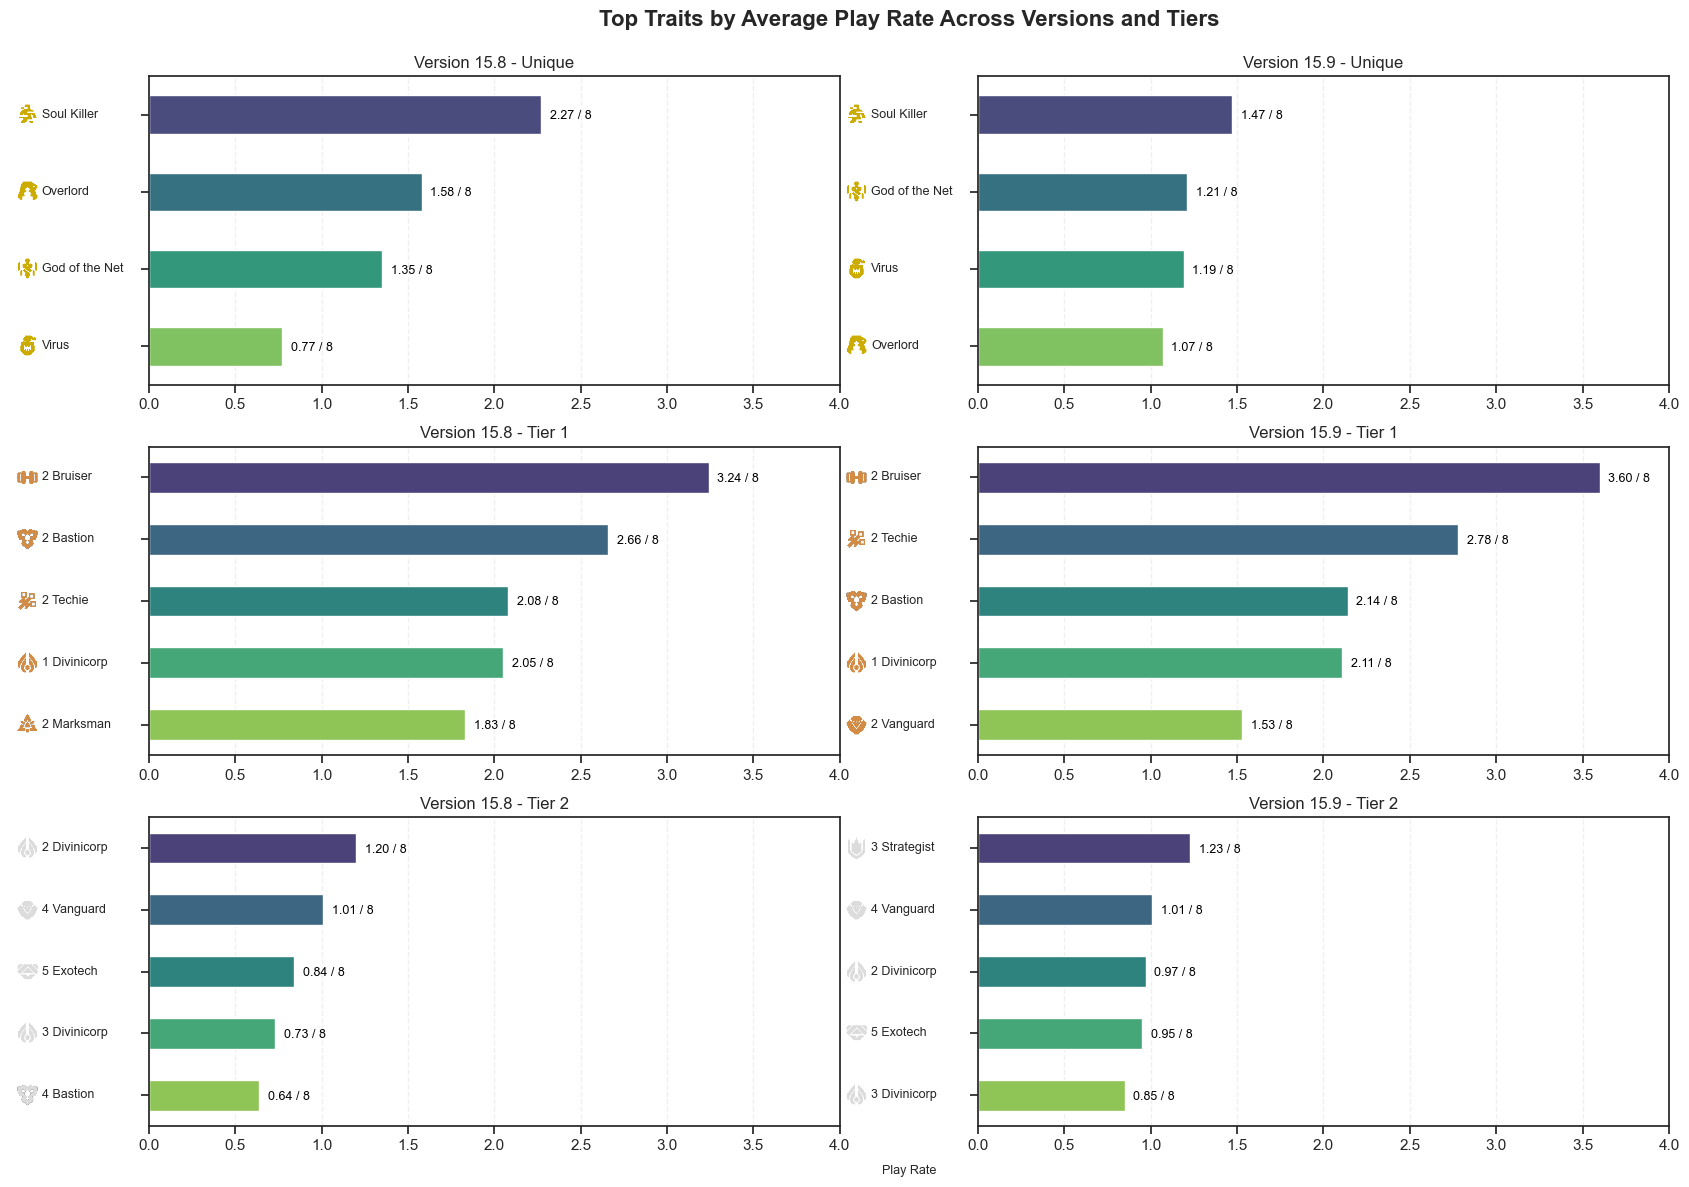

In [32]:
plot_top_traits_by_tier_and_version(
    traits_stats_df=traits_stats_df,
    versions=['15.8', '15.9'],
    tier_order=[3, 1, 2],
    tier_labels={1: 'Tier 1', 2: 'Tier 2', 3: 'Unique', 4: 'Tier 3', 5: 'Tier 4'},
    traits_info=traits_info,
    trait_icons=trait_icons
)

---

<strong>Trait Play Rate Summary</strong>

---

Unique (First Row):

- Because all units in this tier are five-cost and not the main carry in most common compositions.
- Changes in their play rate may happen when popular compositions shift to others that don’t require them anymore or when their stats are nerfed. However, the first situation is more likely.

Tier 1 (Second Row - Bronze):

- Because this trait requires only 1 to 3 units to activate, it is usually added to enhance the power of the key unit in the comp.
- As we can see in the upper plot, the top 4 traits remain the same, with only a position swap between 2 Bastion and 2 Techie, possibly due to the popularity of another composition that also shares the Techie trait.
- The 2 Bruiser trait still holds the highest play rate, as it is the easiest way to strengthen the frontline, similar to how 2 Bastion appears in the top 2 (version 15.8) and top 3 (version 15.9).

Tier 2 (Third Row - Silver):

- This tier represents the middle range of requirements, as most traits here need about 2 to 5 units to activate.
- The popularity of these traits often reflects the popularity of certain compositions in the game, or they may simply be easy traits to activate with 2 or 3 units.

---

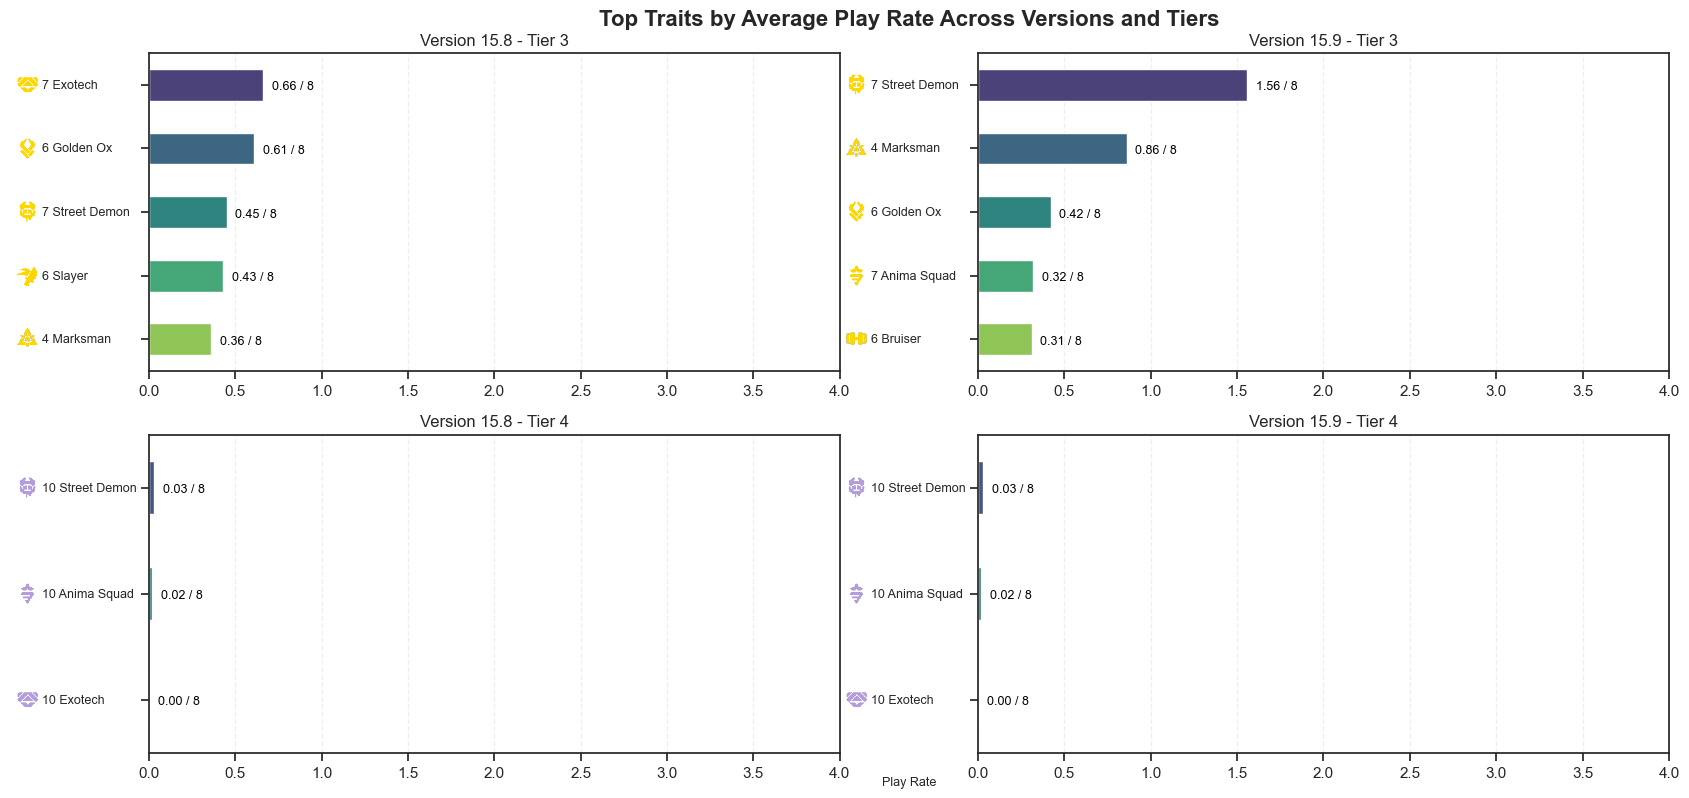

In [33]:
plot_top_traits_by_tier_and_version(
    traits_stats_df=traits_stats_df,
    versions=['15.8', '15.9'],
    tier_order=[4, 5],
    tier_labels={1: 'Tier 1', 2: 'Tier 2', 3: 'Unique', 4: 'Tier 3', 5: 'Tier 4'},
    traits_info=traits_info,
    trait_icons=trait_icons
)

---

<strong>Trait Play Rate Summary</strong>

---

Tier 3 (Forth Row - Gold):

- This tier can be considered the highest trait activation in a typical game. It is commonly used with or without needing just one emblem to activate.
- A trait with a play rate over 1 can be considered overpowered in this patch. In this plot, we can see that 7 Street Demon in patch 15.9 rose from 0.45 (in the previous version) to 1.56. This might be due to an over-buff to the trait and the units that rely on it.

Tier 4 (Last Row - Chromatic):

- This tier represents the most powerful traits in the game. It requires about 2 to 3 emblems to activate, and needs 10 units, meaning players must reach level 10—the highest level in the game.
- Therefore, its play rate is low due to the difficulty of activating it.

---

#### Top traits statistics

In [34]:
def plot_trait_comparison(
    traits_stats_df,
    versions,
    tier_input,
    tier_label,
    trait_icons,
    traits_info,
    top_n=5
):
    # Set seaborn style
    sns.set_theme(style="ticks")
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    # Set colors for the bars
    win_color = (27/255, 158/255, 119/255)
    top4_color = (217/255, 95/255, 2/255)
    avg_color = (117/255, 112/255, 179/255)
    play_rate_color = (231/255, 41/255, 138/255)
    selected_traits_by_version = {v: [] for v in versions}
    
    # Figure setup
    fig, axes = plt.subplots(
        nrows=len(versions),
        ncols=2,
        figsize=(14, 4 * len(versions) + 1)
    )

    if len(versions) == 1:
        axes = np.array([axes]) 

    # ---- Column 0: Win / Top4 rate ----
    for row_idx, version in enumerate(versions):
        ax = axes[row_idx, 0]

        tier_data = traits_stats_df[
            (traits_stats_df['trait_style'] == tier_input) &
            (traits_stats_df['game_version'] == version)
        ]

        top_traits = tier_data.sort_values(by='play_rate', ascending=False).head(top_n).copy()
        top_traits['top4'] *= 100
        top_traits['win'] *= 100

        selected_traits_by_version[version] = [
            (row['trait_id'], row['trait_style'], row['min_units_required'], version)
            for _, row in top_traits.iterrows()
        ]

        # Generate labels based on tier type
        def generate_label(row):
            name = traits_info.get(row['trait_id'], {}).get('name', row['trait_id'])
            return f"{row['min_units_required']} {name}" if tier_label[tier_input] != 'Unique' else name

        top_traits['trait_label'] = top_traits.apply(generate_label, axis=1)

        y_pos = np.arange(len(top_traits))[::-1]
        bar_width = 0.25

        ax.barh(y_pos - bar_width / 2, top_traits['win'], height=bar_width, color=win_color, label='Win Rate')
        ax.barh(y_pos + bar_width / 2, top_traits['top4'], height=bar_width, color=top4_color, label='Top 4 Rate')
        ax.set_title(f'Win & Top4 Rate - Version {version}', fontsize=10)
        ax.set_xlim(0, 100)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([''] * len(top_traits))

        for i, (win_rate, top4_rate) in enumerate(zip(top_traits['win'], top_traits['top4'])):
            ax.text(win_rate + 0.5, y_pos[i] - bar_width / 2, f'{win_rate:.2f}%', ha='left', va='center_baseline', fontsize=8)
            ax.text(top4_rate + 0.5, y_pos[i] + bar_width / 2, f'{top4_rate:.2f}%', ha='left', va='center_baseline', fontsize=8)

        for i, (trait_id, label) in enumerate(zip(top_traits['trait_id'], top_traits['trait_label'])):
            try:
                if trait_id in trait_icons:
                    response = requests.get(trait_icons[trait_id])
                    response.raise_for_status()
                    img = process_trait_image_with_tier(response.content, tier_input)
                    ab = AnnotationBbox(OffsetImage(np.array(img), zoom=0.6), xy=(-0.18, y_pos[i]), xybox=(0, 0),
                                        xycoords=('axes fraction', 'data'), boxcoords="offset points",
                                        box_alignment=(1, 0.5), frameon=False)
                    ax.add_artist(ab)
            except Exception as e:
                print(f"Failed to load icon for {trait_id}: {e}")

            ax.text(x=-0.175, y=y_pos[i], s=label, ha='left', va='center', fontsize=9, transform=ax.get_yaxis_transform())

    # ---- Column 1: Play Rate / Avg Placement ----
    for row_idx, version in enumerate(versions):
        ax = axes[row_idx, 1]

        trait_data = traits_stats_df[traits_stats_df['trait_style'] == tier_input].copy()
        trait_data['trait_key'] = list(zip(trait_data['trait_id'], trait_data['trait_style'],
                                        trait_data['min_units_required'], trait_data['game_version']))
        selected_keys = selected_traits_by_version[version]
        trait_data = trait_data[trait_data['trait_key'].isin(selected_keys)].copy()
        trait_data['sort_order'] = trait_data['trait_key'].apply(lambda x: selected_keys.index(x))
        filtered = trait_data.sort_values('sort_order')

        filtered['trait_label'] = filtered.apply(generate_label, axis=1)

        y_pos = np.arange(len(filtered))[::-1]
        bar_width = 0.25

        ax.barh(y_pos - bar_width / 2, filtered['play_rate'], height=bar_width, color=play_rate_color, label='Play Rate')
        ax.barh(y_pos + bar_width / 2, filtered['avg_place'], height=bar_width, color=avg_color, label='Avg Placement')

        ax.set_title(f'Avg Placement - Version {version}', fontsize=10)
        ax.set_xlim(0, 8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([''] * len(filtered))

        for i, (play_rate, avg_place) in enumerate(zip(filtered['play_rate'], filtered['avg_place'])):
            ax.text(play_rate + 0.04, y_pos[i] - bar_width / 2, f'{play_rate:.2f} / 8', ha='left', va='center_baseline', fontsize=8)
            ax.text(avg_place + 0.04, y_pos[i] + bar_width / 2, f'{avg_place:.2f}', ha='left', va='center_baseline', fontsize=8)

        for i, (trait_id, label) in enumerate(zip(filtered['trait_id'], filtered['trait_label'])):
            try:
                if trait_id in trait_icons:
                    response = requests.get(trait_icons[trait_id])
                    response.raise_for_status()
                    img = process_trait_image_with_tier(response.content, tier_input)
                    ab = AnnotationBbox(OffsetImage(np.array(img), zoom=0.6), xy=(-0.18, y_pos[i]), xybox=(0, 0),
                                        xycoords=('axes fraction', 'data'), boxcoords="offset points",
                                        box_alignment=(1, 0.5), frameon=False)
                    ax.add_artist(ab)
            except Exception as e:
                print(f"Failed to load icon for {trait_id}: {e}")

            ax.text(x=-0.175, y=y_pos[i], s=label, ha='left', va='center', fontsize=9, transform=ax.get_yaxis_transform())

    # ---- Final formatting ----
    fig.suptitle(f'Trait Analysis for {tier_label[tier_input]}', fontsize=16, fontweight='bold', y=0.96)
    fig.subplots_adjust(
        top=0.85,
        bottom=0.1, left=0.025, right=0.975,
        hspace=0.2, wspace=0.25
    )

    # Legend
    patches = [
        mpatches.Patch(color=top4_color, label='Top 4 Rate'),
        mpatches.Patch(color=win_color, label='Win Rate'),
        mpatches.Patch(color=avg_color, label='Avg Placement'),
        mpatches.Patch(color=play_rate_color, label='Play Rate')
    ]
    fig.legend(
        handles=patches, loc='upper center',
        bbox_to_anchor=(0.5, 0.925), ncol=4,
        fontsize=9, frameon=True
    )

    plt.show()

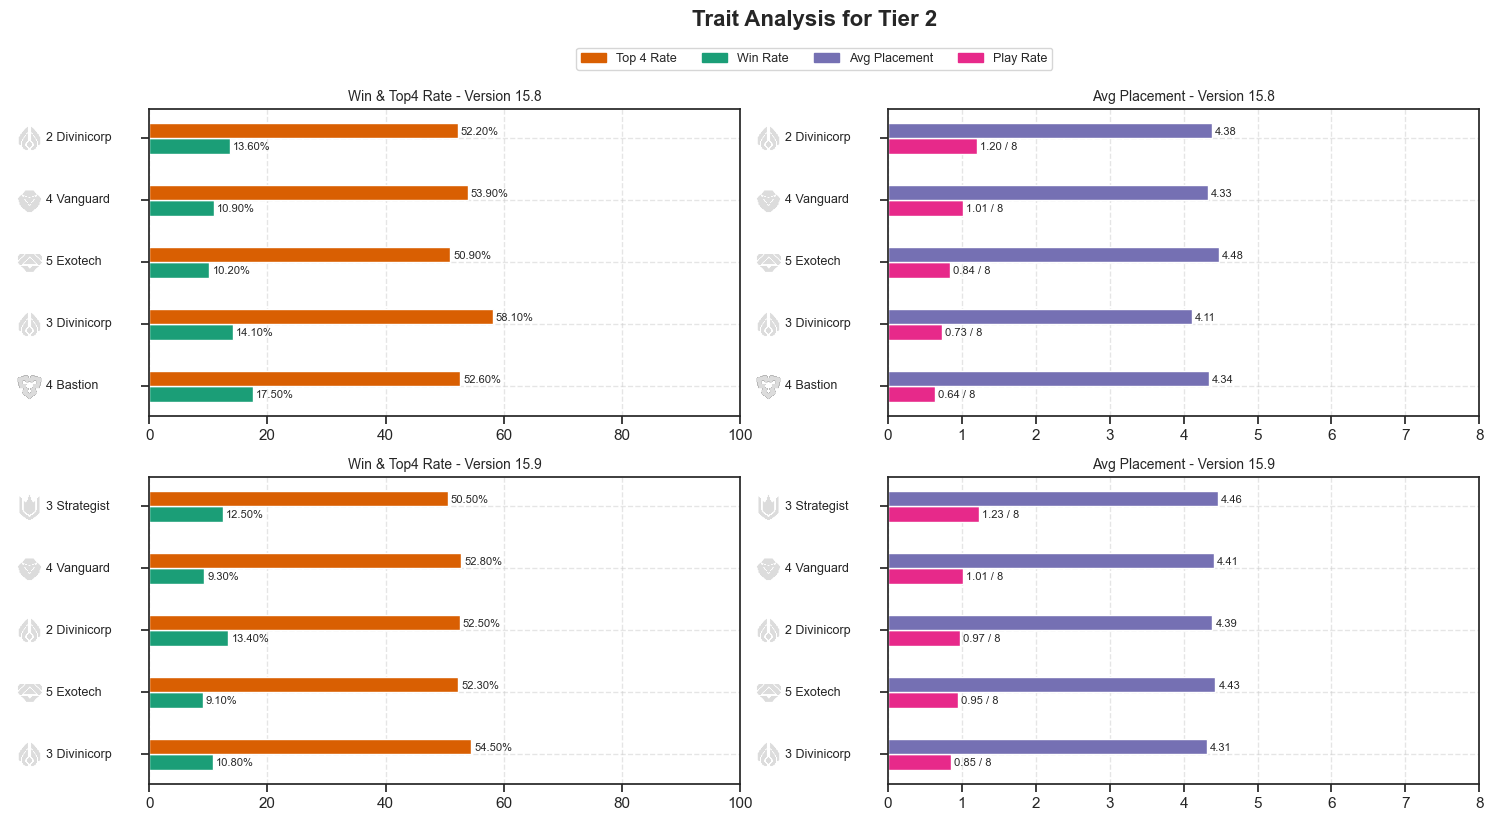

In [35]:
plot_trait_comparison(
    traits_stats_df=traits_stats_df,
    versions=['15.8', '15.9'],
    tier_input=2,
    tier_label={2: 'Tier 2'},
    trait_icons=trait_icons,
    traits_info=traits_info
)

---

<strong>Trait Statistics Summary Tier 2</strong>

---

Top 4 and Win Rate Trends

- Patch 15.8:
  - 3 Divinicorp had the highest top 4 rate (58.1%) with a 14.1% win rate, making it the best-performing trait in this set.
  - 2 Divinicorp, Vanguard, Exotech, and Bastion followed with around 50-54% top 4 rates and 10-17% win rates, showing a balanced presence in the game.
  - Bastion had the highest win rate (17.5%) but only a mid-level top 4 rate, placing it as a high-risk, high-reward option.
- Patch 15.9:
  - 3 Divinicorp again showed the highest top 4 rate (54.5%), but its win rate dropped to 10.8%, weakening its overall impact.
  - 2 Divinicorp, Vanguard, Exotech, and Strategist clustered around 50-53% top 4, showing no standout improvement.
  - Strategist posted moderate results with a 12.5% win rate and 50.5% top 4 rate, but nothing dominant.

Average Placement Trends

- Patch 15.8:
  - All traits averaged between 4.11 and 4.48 in placement, showing mediocre performance overall.
  - 3 Divinicorp performed the best with an average placement of 4.11, while Exotech had the worst at 4.48.
- Patch 15.9:
  - 3 Divinicorp again led with the best average placement (4.31), but the overall average worsened across all traits, ranging from 4.31 to 4.46.
  - Placement slightly declined across the board, suggesting a weaker overall impact of Tier 2 traits in patch 15.9.

---

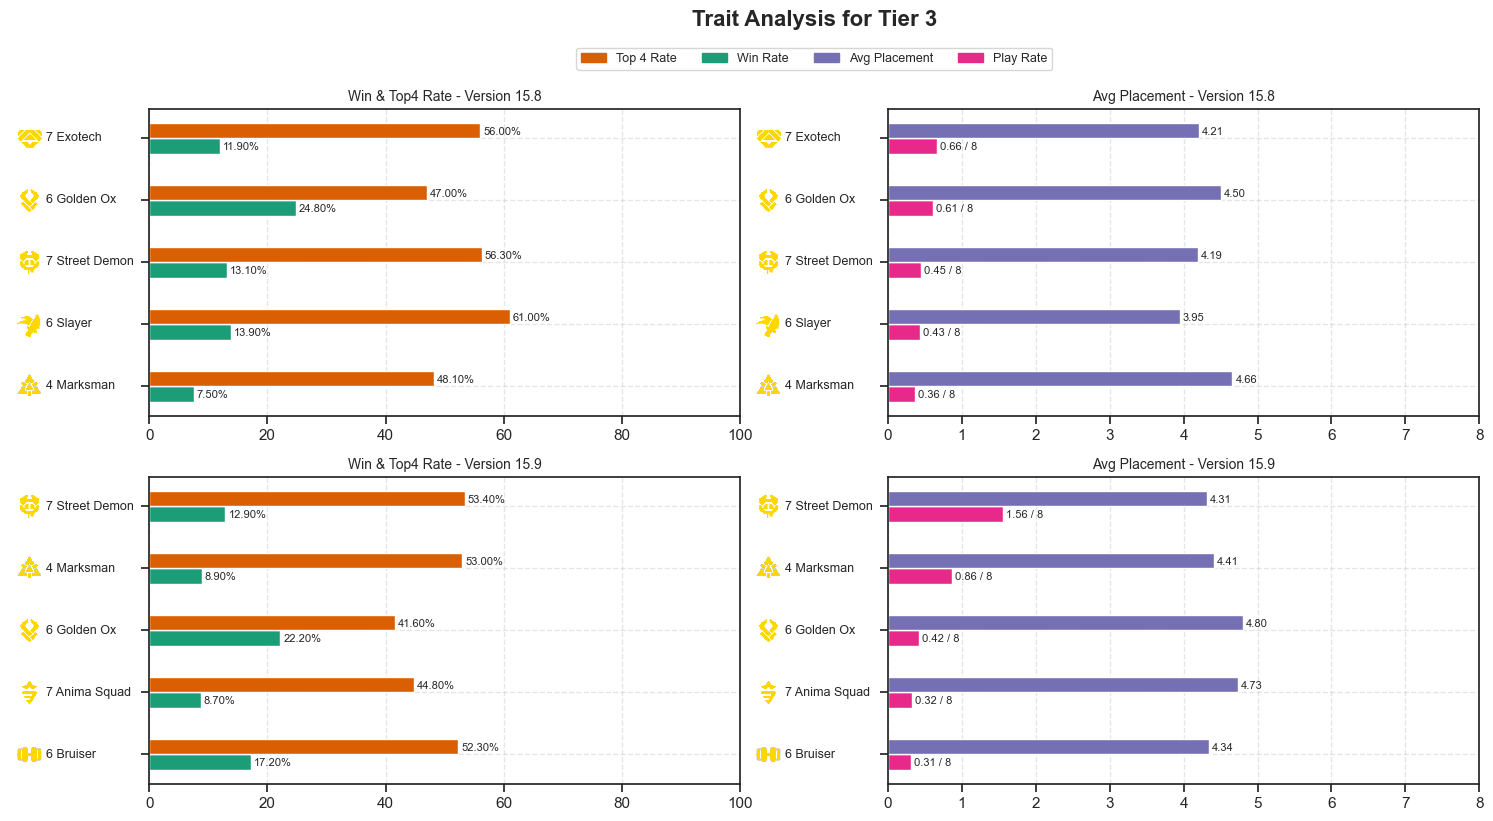

In [36]:
plot_trait_comparison(
    traits_stats_df=traits_stats_df,
    versions=['15.8', '15.9'],
    tier_input=4,
    tier_label={4: 'Tier 3'},
    trait_icons=trait_icons,
    traits_info=traits_info
)

---

<strong>Trait Statistics Summary Tier 3</strong>

---

Top 4 and Win Rate Trends

- Patch 15.8:
  - 6 Slayer led with the highest top 4 rate (61.0%) and a 13.9% win rate, making it the best performer.
  - 7 Street Demon and 7 Exotech both posted around 56% top 4 rates with 11-13% win rates, positioning them as solid mid-meta options.
  - 6 Golden Ox had the highest win rate (24.8%) but lower top 4 consistency (47.0%), showing more volatile results.
  - 4 Marksman was the weakest overall, with low top 4 (48.1%) and win rate (7.5%).
- Patch 15.9:
  - Despite its very high play rate (1.56 out of 8), 7 Street Demon remained stable at 52.3% top 4 and 17.2% win rate, making it the hottest trait in this version.
  - 6 Bruiser emerged as a new meta contender, with 52.3% top 4 and an 17.2% win rate, making it the strongest closer in this patch.
  - 6 Golden Ox dropped to a 41.6% top 4 rate but maintained a solid 22.2% win rate, still offering high-risk, high-reward value.
  - 4 Marksman and 7 Anima Squad showed similarly weak results, with around 45-53% top 4 and only 9% win rates.

Average Placement Trends

- Patch 15.8:
  - 6 Slayer again led with a 3.95 average placement, confirming its overall consistency.
  - 7 Street Demon and 7 Exotech followed with averages around 4.19-4.21, showing respectable performance.
  - 6 Golden Ox and 4 Marksman struggled with 4.50 and 4.66 averages, placing them below average.
- Patch 15.9:
  - 6 Bruiser and 7 Street Demon had the best placements, averaging around 4.31-4.34, confirming their viability.
  - 4 Marksman, 7 Anima Squad, and 6 Golden Ox underperformed with average placements around 4.41-4.80, showing they lack consistency compared to other traits.

---

## Save Results

In [37]:
# For notebooks only
current_path = os.getcwd()
project_root = os.path.abspath(os.path.join(current_path, "../.."))
sys.path.append(project_root)

# Path to data/processed directory
base_path = os.path.join(project_root, "data", "processed")

# Define all paths
units_path = os.path.join(base_path, "units_basic_stats.csv")
item_units_path = os.path.join(base_path, "units_items_stats.csv")
items_path = os.path.join(base_path, "items_stats.csv")
traits_path = os.path.join(base_path, "traits_stats.csv")
comps_path = os.path.join(base_path, "comps_stats.csv")

In [38]:
# Load CSVs
units_basic_stats_df.to_csv(units_path, index=False)
units_items_stats_df.to_csv(item_units_path, index=False)
items_stats_df.to_csv(items_path, index=False)
traits_stats_df.to_csv(traits_path, index=False)
comps_stats_df.to_csv(comps_path, index=False)